In [20]:
from kaggle_datasets import KaggleDatasets
from glob import glob
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Add, Concatenate, Input, ZeroPadding2D
from sklearn.model_selection import train_test_split
import warnings
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf


AUTOTUNE = tf.data.experimental.AUTOTUNE
warnings.filterwarnings('ignore')

# TPU 사용 with strategy.scope()를 이용해 원하는 연산에 사용
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

Device: grpc://10.0.0.2:8470


2022-12-03 22:15:49.453494: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-03 22:15:49.453630: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-12-03 22:15:49.455708: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-03 22:15:49.455747: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


# 파일 불러오기 및 전처

In [21]:
PATH1 = KaggleDatasets().get_gcs_path('ayaan-data') # 캐글에 데이터 셋 올려서 받기. 코랩터짐..

COMICS = tf.io.gfile.glob(str(PATH1 + '/comics/*'))
print('Comics:', len(COMICS))

FACES = tf.io.gfile.glob(str(PATH1 + '/face/*'))
print('Faces:', len(FACES))

REAL_FACES = tf.io.gfile.glob(str(PATH1 + '/face2/*'))
print('Faces2:', len(REAL_FACES))

2022-12-03 22:15:56.882945: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:56.949740: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:57.029173: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:57.094676: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:57.161180: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Comics: 10000


2022-12-03 22:15:57.587731: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:57.670783: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:57.737907: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:57.804747: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:57.888548: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Faces: 10000


2022-12-03 22:15:58.311573: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:58.377734: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:58.445063: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:58.508686: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 22:15:58.576470: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Faces2: 7219


In [22]:
import random
EXTRA_COMIC = random.sample(COMICS,len(REAL_FACES))
random.shuffle(FACES)
random.shuffle(COMICS)

In [23]:
ALL_FACES = FACES + REAL_FACES
ALL_COMICS = EXTRA_COMIC + COMICS
print(len(ALL_FACES), len(ALL_COMICS))

17219 17219


In [24]:
BATCH_SIZE = 32 #gpu는 터지는데 케글 tpu는 안터짐
BUFFER_SIZE = 1000
TEST_SIZE = 0.01
IMG_H, IMG_W = 256, 256
HEIGHT = 256
WIDTH = 256
CROP = 256
CHANNELS = 3
# 라벨이 0과 1 사이의 값으로 구성 - 유연한예측
LABEL_SMOOTHING = 0.1
TRANSFORMER_BLOCKS = 6

GENERATOR_LEARN = 1e-4
DISCRIMINATOR_LEARN = 5e-4

In [25]:
train_comics, test_comics, train_faces, test_faces = train_test_split(ALL_COMICS, ALL_FACES, test_size=TEST_SIZE, random_state=420)

In [26]:
@tf.function()
def random(comic, face):
    comic, face = resize(comic, face, IMG_H, IMG_W)
    comic, face = random_crop(comic, face, CROP, CROP)

    if tf.random.uniform(()) > 0.5: 
        comic = tf.image.flip_left_right(comic)
        face = tf.image.flip_left_right(face)

    return comic, face

def preprocess(comic_path, face_path):
    comic, face = load(comic_path, face_path)

    return comic, face

def imgaug(comic,face):
    comic,face = random(comic,face)
    comic,face = normalize(comic, face)
    
    return comic, face

def load(comic_path,face_path):
# 불러오기
    comic = tf.io.read_file(comic_path)
    comic = tf.image.decode_jpeg(comic, channels=3)

    face = tf.io.read_file(face_path)
    face = tf.image.decode_jpeg(face, channels=3)
    
    return comic ,face

def normalize(comic, face):
# 정규화
    comic = (tf.cast(comic, tf.float32) /255.0 *2) -1
    face = (tf.cast(face, tf.float32) /255.0 *2) -1
    
    return comic, face

def random_crop(comic, face, height, width):
# 두 이미지를 stack 후 랜덤으로 자르기
    stack_image = tf.stack([comic, face], axis=0)
    crop_image = tf.image.random_crop(stack_image, 
                                         size=[2, height, width, 3])

    return crop_image[0], crop_image[1]

def resize(comic, face, height, width):
# 사이즈 조정
    comic = tf.image.resize(comic, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    face = tf.image.resize(face, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return comic, face

In [27]:
# buffer_size를 조절해야 안터짐. TPU 기준 400보다 좀더 키워도 될듯
train_ds = tf.data.Dataset.from_tensor_slices((train_comics,train_faces))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
train_ds = train_ds.repeat().shuffle(buffer_size=BUFFER_SIZE,reshuffle_each_iteration=True).map(imgaug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_comics, test_faces))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.repeat().shuffle(buffer_size=50).map(imgaug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# 모델

In [28]:
# Model

conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def enc_block(input_layer, filters, size=3, strides=2, instancenorm=True, spectral=False, activation=LeakyReLU(0.2), name='block_x'):
    
    if (spectral) & (instancenorm == False):
        out = tfa.layers.SpectralNormalization(Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}'))(input_layer)
    else: 
        out =  Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if instancenorm:
        out = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(out)
        
    out = activation(out)

    return out

def dec_block(input_layer, filters, size=3, strides=2, instancenorm=True, spectral=False, name='block_x'):
    
    if (spectral) & (instancenorm == False):
        # discriminator의 학습을 안정화시키는 방법
        out = tfa.layers.SpectralNormalization(Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}'))(input_layer)
    else:
    
        out = Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)

    if instancenorm:
        out = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(out)

    out = LeakyReLU()(out)
    
    return out

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    out = Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
    out = LeakyReLU(0.2)(out)
    
    out = Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(out)    
    out = Add()([out, input_layer])

    return out

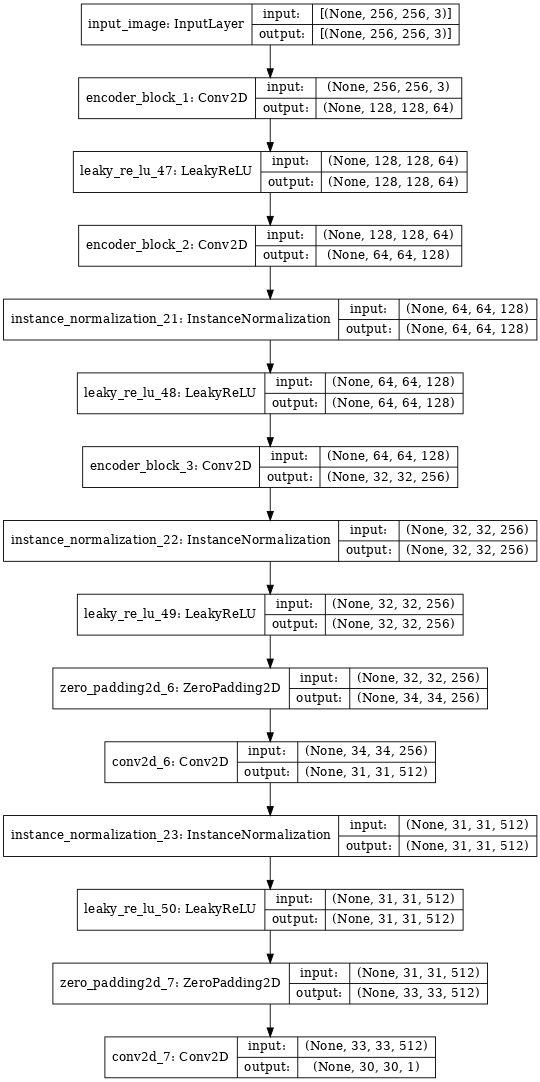

In [29]:
# Discriminator

def discriminator():

    inp = Input(shape=[256, 256, 3], name='input_image')

    x = inp
    enc1 = enc_block(x, 64,  4, 2, instancenorm=False, activation=LeakyReLU(0.2), name='block_1')
    enc2 = enc_block(enc1, 128, 4, 2, instancenorm=True, spectral=False, activation=LeakyReLU(0.2), name='block_2') 
    enc3 = enc_block(enc2, 256, 4, 2, instancenorm=True, spectral=False, activation=LeakyReLU(0.2), name='block_3') 

    zero_pad1 = ZeroPadding2D()(enc3) 
    conv = Conv2D(512, 4, strides=1, kernel_initializer=conv_initializer,use_bias=False)(zero_pad1)
    # Instance Normalization은 주로 이미지 스타일 변환에 사용. 클래스 레이블이 입력 이미지의 명암에 의존하지 않아야하는 이미지 분류에 인스턴스 정규화 사용
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(conv)

    lrelu = LeakyReLU(0.2)(norm1)

    zero_pad2 = ZeroPadding2D()(lrelu)

    last = Conv2D(1, 4, strides=1, kernel_initializer=conv_initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

tf.keras.utils.plot_model(discriminator(), show_shapes=True, dpi=64)

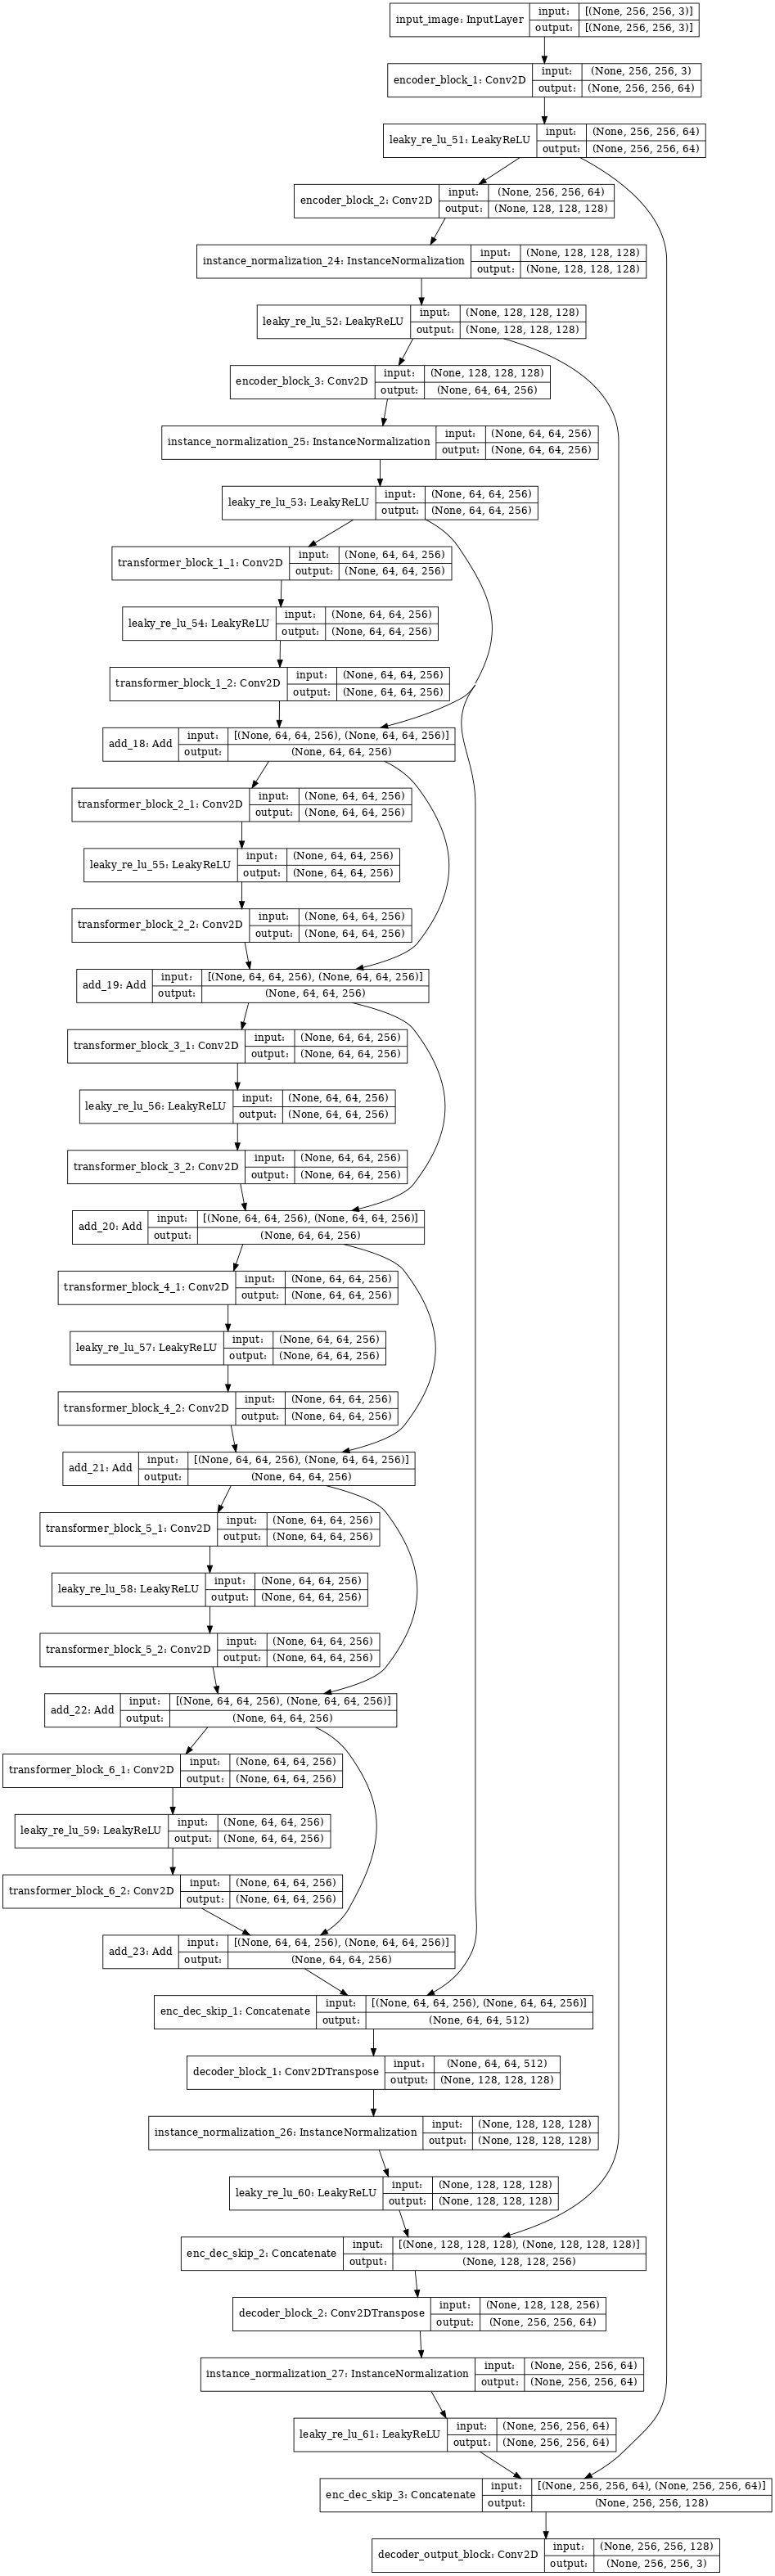

In [30]:
# Generator
def generator_function(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = Input(shape=[height, width, channels], name='input_image')

    # 인코더
    enc1 = enc_block(inputs, 64,  7, 1, instancenorm=False, activation=LeakyReLU(0.2), name='block_1')
    enc2 = enc_block(enc1, 128, 3, 2, instancenorm=True, spectral=False, activation=LeakyReLU(0.2), name='block_2')
    enc3 = enc_block(enc2, 256, 3, 2, instancenorm=True, spectral=False, activation=LeakyReLU(0.2), name='block_3')
    
    # 트랜스포머
    x = enc3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}')

    # 디코더 - 인코더 디코더 스킵
    skip = Concatenate(name='enc_dec_skip_1')([x, enc3]) 
    
    dec1 = dec_block(skip, 128, 3, 2, instancenorm=True, spectral=False, name='block_1') 
    skip = Concatenate(name='enc_dec_skip_2')([dec1, enc2])
    
    dec2 = dec_block(skip, 64,  3, 2, instancenorm=True, spectral=False, name='block_2')
    skip = Concatenate(name='enc_dec_skip_3')([dec2, enc1]) 

    outputs = last = Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=1, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(skip)

    generator = tf.keras.Model(inputs, outputs)
    
    return generator

sample_gen = generator_function()

tf.keras.utils.plot_model(sample_gen, show_shapes=True, dpi=64)

In [31]:
with strategy.scope():
    comics_gen = generator_function(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) 
    faces_gen = generator_function(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS)

    comics_disc = discriminator() 
    faces_disc = discriminator() 

class Cyclegan(tf.keras.Model):
    def __init__(
        self,
        comics_gen,
        faces_gen,
        comics_disc,
        faces_disc,
        lambda_cycle=10,
    ):
        super(Cyclegan, self).__init__()
        self.c_gen = comics_gen
        self.f_gen = faces_gen
        self.c_disc = comics_disc
        self.f_disc = faces_disc
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        c_gen_opt,
        f_gen_opt,
        c_disc_opt,
        f_disc_opt,
        gen_loss,
        disc_loss,
        cycle_loss,
        identity_loss
    ):
        super(Cyclegan, self).compile()
        self.c_gen_opt = c_gen_opt
        self.f_gen_opt= f_gen_opt
        self.c_disc_opt = c_disc_opt
        self.f_disc_opt = f_disc_opt
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        self.cycle_loss = cycle_loss
        self.identity_loss = identity_loss
        
    def train_step(self, batch_data):
        real_comic, real_face = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # face->comic->face
            fake_comic = self.c_gen(real_face, training=True)
            cycle_face = self.f_gen(fake_comic, training=True)

            # comic->face->comic
            fake_face = self.f_gen(real_comic, training=True)
            cycle_comic = self.c_gen(fake_face, training=True)

            # comic->comic, face->face
            same_comic = self.c_gen(real_comic, training=True)
            same_face = self.f_gen(real_face, training=True)

            # 판별기 실제 이미지 입력
            disc_real_comic = self.c_disc(real_comic, training=True)
            disc_real_face = self.f_disc(real_face, training=True)

            # 판별기 가짜 이미지 입력
            disc_fake_comic = self.c_disc(fake_comic, training=True)
            disc_fake_face = self.f_disc(fake_face, training=True)

            comic_gen_loss = self.gen_loss(disc_fake_comic)
            face_gen_loss = self.gen_loss(disc_fake_face)

            sum_cycle_loss = self.cycle_loss(real_comic, cycle_comic, self.lambda_cycle) + self.cycle_loss(real_face, cycle_face, self.lambda_cycle)

            sum_comic_gen_loss = comic_gen_loss + sum_cycle_loss + self.identity_loss(real_comic, same_comic, self.lambda_cycle)
            sum_face_gen_loss = face_gen_loss + sum_cycle_loss + self.identity_loss(real_face, same_face, self.lambda_cycle)

            comic_disc_loss = self.disc_loss(disc_real_comic, disc_fake_comic)
            face_disc_loss = self.disc_loss(disc_real_face, disc_fake_face)

        comic_gen_gradients = tape.gradient(sum_comic_gen_loss, self.c_gen.trainable_variables)
        face_gen_gradients = tape.gradient(sum_face_gen_loss, self.f_gen.trainable_variables)

        comic_disc_gradients = tape.gradient(comic_disc_loss, self.c_disc.trainable_variables)
        face_disc_gradients = tape.gradient(face_disc_loss, self.f_disc.trainable_variables)

        self.c_gen_opt.apply_gradients(zip(comic_gen_gradients, self.c_gen.trainable_variables))
        self.f_gen_opt.apply_gradients(zip(face_gen_gradients, self.f_gen.trainable_variables))
        self.c_disc_opt.apply_gradients(zip(comic_disc_gradients, self.c_disc.trainable_variables))
        self.f_disc_opt.apply_gradients(zip(face_disc_gradients, self.f_disc.trainable_variables))
        
        return {
            "comic_gen_loss": sum_comic_gen_loss,
            "face_gen_loss": sum_face_gen_loss,
            "comic_disc_loss": comic_disc_loss,
            "face_disc_loss": face_disc_loss
        }

with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE,label_smoothing=LABEL_SMOOTHING)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE,label_smoothing=LABEL_SMOOTHING)(tf.zeros_like(generated), generated)

        sum_disc_loss = real_loss + generated_loss

        return sum_disc_loss * 0.5

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

with strategy.scope():
    comic_gen_opt = tf.keras.optimizers.Adam(GENERATOR_LEARN, beta_1=0.5)
    face_gen_opt = tf.keras.optimizers.Adam(GENERATOR_LEARN, beta_1=0.5)

    comic_disc_opt = tf.keras.optimizers.Adam(DISCRIMINATOR_LEARN, beta_1=0.5)
    face_disc_opt = tf.keras.optimizers.Adam(DISCRIMINATOR_LEARN, beta_1=0.5)

In [32]:
with strategy.scope():
    cyclegan_model = Cyclegan(comics_gen, faces_gen, comics_disc, faces_disc)

    cyclegan_model.compile(
        c_gen_opt = comic_gen_opt,
        f_gen_opt = face_gen_opt,
        c_disc_opt = comic_disc_opt,
        f_disc_opt = face_disc_opt,
        gen_loss = generator_loss,
        disc_loss = discriminator_loss,
        cycle_loss = calc_cycle_loss,
        identity_loss = identity_loss
    )

def generate_images(model, test_input,epoch,save_path = ''):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(10,10))

    display_list = [test_input[0], prediction[0]]

    title = ['Input Image', 'Output Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    if save_path != '':
        plt.savefig(f'{save_path}/{epoch}.jpg', pad_inches=0.3, bbox_inches='tight')
        

    plt.show()

In [33]:
!mkdir comic_gen_jpg
!mkdir real_gen_jpg

mkdir: cannot create directory ‘comic_gen_jpg’: File exists
mkdir: cannot create directory ‘real_gen_jpg’: File exists


In [34]:
from tensorflow.keras.callbacks import Callback

class ganmonitor(Callback):
    def __init__(self, num=1,save_epoch=4,watch_epoch=2,save_dir='./'):
        self.num = num
        self.save_epoch = save_epoch
        self.watch_epoch = watch_epoch
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):

        if epoch % self.watch_epoch == 0:
            # 사진에서 코믹으로 저장
            for example_input, example_output in test_ds.take(self.num): 
                generate_images(comics_gen, example_output,epoch,save_path = './comic_gen_jpg')
            # 코믹에서 사진으로 저장
            for example_input, example_output in test_ds.take(self.num):
                generate_images(faces_gen, example_input, epoch,save_path='./real_gen_jpg')
                
        if (epoch > 0) & (epoch % self.save_epoch == 0):
            # 생성모델 저장
            comics_gen.save(f"{self.save_dir}/comic_gen{epoch}.h5",save_format='h5',overwrite=True)
            faces_gen.save(f"{self.save_dir}/real_gen{epoch}.h5",save_format='h5',overwrite=True)

In [35]:
STEP=len(train_comics)//BATCH_SIZE
print(STEP)

532


Epoch 1/50
532/532 [==============================] - 729s 1s/step - comic_gen_loss: 4.2951 - face_gen_loss: 4.1063 - comic_disc_loss: 0.4792 - face_disc_loss: 0.5313


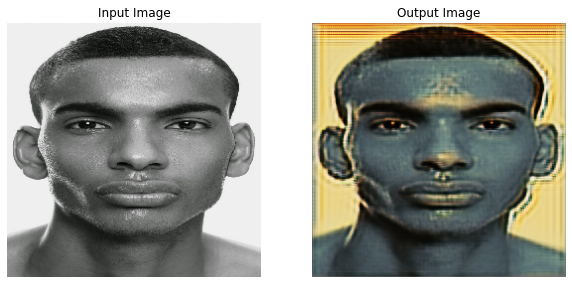

2022-12-03 22:28:21.172909: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 48029, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670106501.172816814","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 48029, Output num: 1","grpc_status":3}


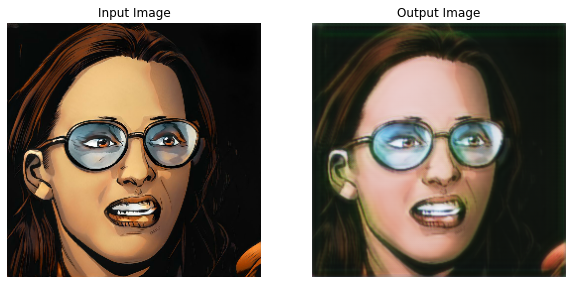

Epoch 2/50
532/532 [==============================] - 216s 407ms/step - comic_gen_loss: 3.8798 - face_gen_loss: 3.6567 - comic_disc_loss: 0.4922 - face_disc_loss: 0.5719
Epoch 3/50
532/532 [==============================] - 217s 407ms/step - comic_gen_loss: 3.7766 - face_gen_loss: 3.5173 - comic_disc_loss: 0.4655 - face_disc_loss: 0.5737
Epoch 4/50
532/532 [==============================] - 217s 407ms/step - comic_gen_loss: 3.6823 - face_gen_loss: 3.4759 - comic_disc_loss: 0.5048 - face_disc_loss: 0.5733
Epoch 5/50
532/532 [==============================] - 217s 407ms/step - comic_gen_loss: 3.5725 - face_gen_loss: 3.4362 - comic_disc_loss: 0.5246 - face_disc_loss: 0.5754
Epoch 6/50
532/532 [==============================] - 217s 407ms/step - comic_gen_loss: 3.3732 - face_gen_loss: 3.3292 - comic_disc_loss: 0.5453 - face_disc_loss: 0.5847


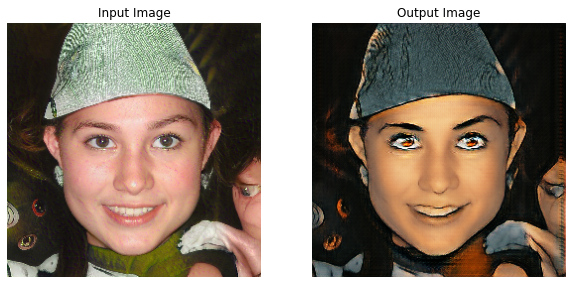

2022-12-03 22:46:39.802051: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 72563, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670107599.801819944","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 72563, Output num: 0","grpc_status":3}


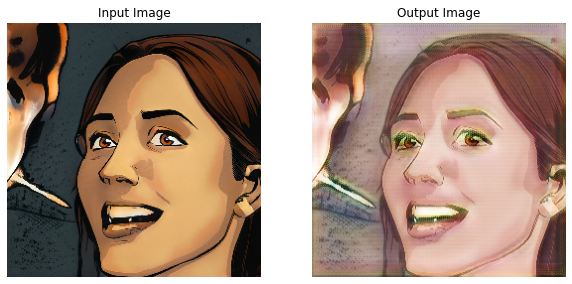

Epoch 7/50
532/532 [==============================] - 217s 407ms/step - comic_gen_loss: 3.3482 - face_gen_loss: 3.2226 - comic_disc_loss: 0.5289 - face_disc_loss: 0.5909
Epoch 8/50
532/532 [==============================] - 217s 407ms/step - comic_gen_loss: 3.2022 - face_gen_loss: 3.1216 - comic_disc_loss: 0.5907 - face_disc_loss: 0.6043
Epoch 9/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 3.1316 - face_gen_loss: 3.0201 - comic_disc_loss: 0.5478 - face_disc_loss: 0.6123
Epoch 10/50
532/532 [==============================] - 217s 407ms/step - comic_gen_loss: 3.0341 - face_gen_loss: 2.9375 - comic_disc_loss: 0.5803 - face_disc_loss: 0.6203
Epoch 11/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.9021 - face_gen_loss: 2.8470 - comic_disc_loss: 0.6187 - face_disc_loss: 0.6304


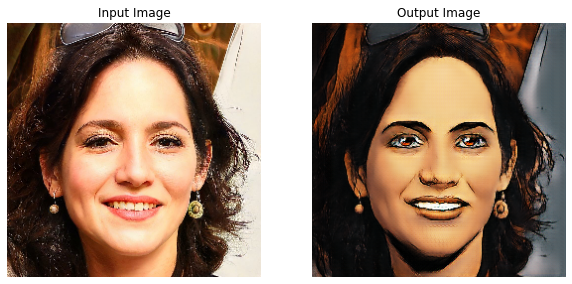

2022-12-03 23:04:59.862579: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 97097, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670108699.862491969","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 97097, Output num: 0","grpc_status":3}


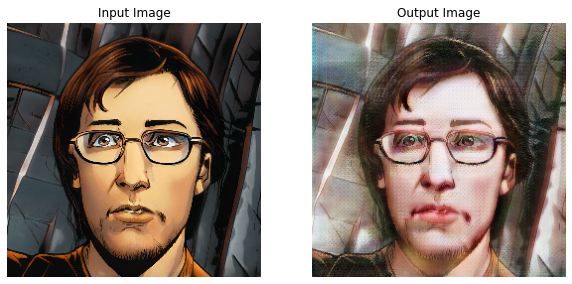

Epoch 12/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8968 - face_gen_loss: 2.7557 - comic_disc_loss: 0.5704 - face_disc_loss: 0.6355
Epoch 13/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.6631 - face_gen_loss: 2.6454 - comic_disc_loss: 0.6269 - face_disc_loss: 0.6369
Epoch 14/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8212 - face_gen_loss: 2.6785 - comic_disc_loss: 0.5786 - face_disc_loss: 0.6383
Epoch 15/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8092 - face_gen_loss: 2.6299 - comic_disc_loss: 0.5685 - face_disc_loss: 0.6397
Epoch 16/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7797 - face_gen_loss: 2.5926 - comic_disc_loss: 0.5635 - face_disc_loss: 0.6428


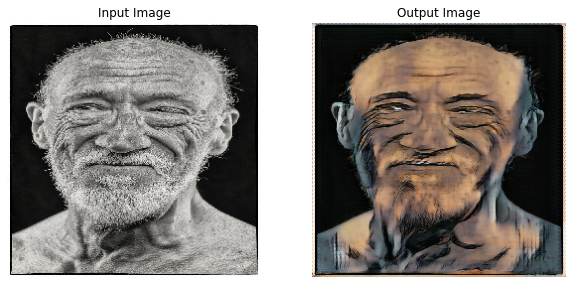

2022-12-03 23:23:21.429819: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 121839, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670109801.429700243","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 121839, Output num: 1","grpc_status":3}


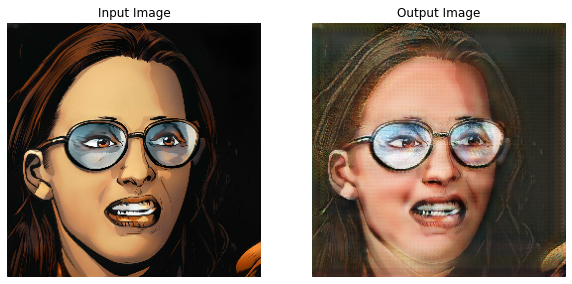

Epoch 17/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7242 - face_gen_loss: 2.5688 - comic_disc_loss: 0.6085 - face_disc_loss: 0.6407
Epoch 18/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7708 - face_gen_loss: 2.5560 - comic_disc_loss: 0.5571 - face_disc_loss: 0.6416
Epoch 19/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7547 - face_gen_loss: 2.5521 - comic_disc_loss: 0.5896 - face_disc_loss: 0.6434
Epoch 20/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.6756 - face_gen_loss: 2.4958 - comic_disc_loss: 0.5756 - face_disc_loss: 0.6380
Epoch 21/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7105 - face_gen_loss: 2.4733 - comic_disc_loss: 0.5636 - face_disc_loss: 0.6409


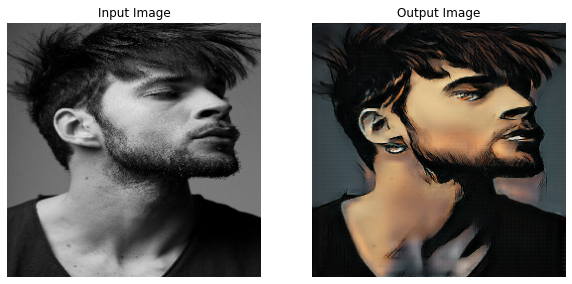

2022-12-03 23:41:42.869111: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 146373, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670110902.869016478","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 146373, Output num: 1","grpc_status":3}


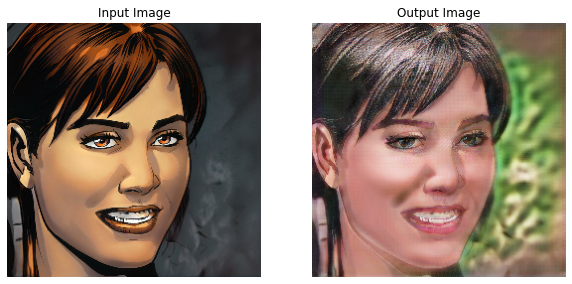

Epoch 22/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8012 - face_gen_loss: 2.4841 - comic_disc_loss: 0.5337 - face_disc_loss: 0.6410
Epoch 23/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7570 - face_gen_loss: 2.4701 - comic_disc_loss: 0.5667 - face_disc_loss: 0.6407
Epoch 24/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8592 - face_gen_loss: 2.4691 - comic_disc_loss: 0.5097 - face_disc_loss: 0.6434
Epoch 25/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8739 - face_gen_loss: 2.5561 - comic_disc_loss: 0.5695 - face_disc_loss: 0.6304
Epoch 26/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.9053 - face_gen_loss: 2.6240 - comic_disc_loss: 0.5272 - face_disc_loss: 0.6215


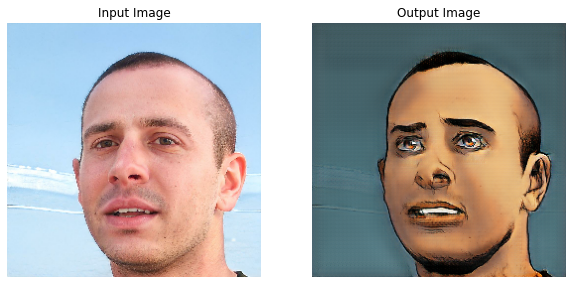

2022-12-04 00:00:04.955795: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 171115, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670112004.955628672","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 171115, Output num: 0","grpc_status":3}


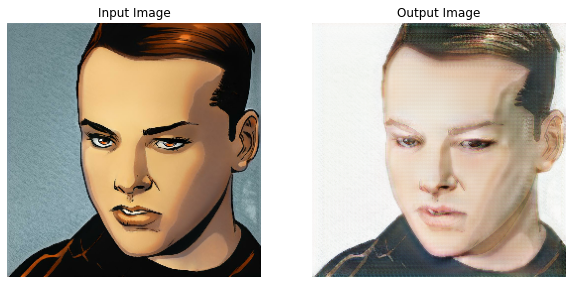

Epoch 27/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7794 - face_gen_loss: 2.4545 - comic_disc_loss: 0.5344 - face_disc_loss: 0.6366
Epoch 28/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7135 - face_gen_loss: 2.4125 - comic_disc_loss: 0.5717 - face_disc_loss: 0.6428
Epoch 29/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7507 - face_gen_loss: 2.4116 - comic_disc_loss: 0.5329 - face_disc_loss: 0.6436
Epoch 30/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 3.2963 - face_gen_loss: 2.9609 - comic_disc_loss: 0.4853 - face_disc_loss: 0.5830
Epoch 31/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7198 - face_gen_loss: 2.4158 - comic_disc_loss: 0.5658 - face_disc_loss: 0.6438


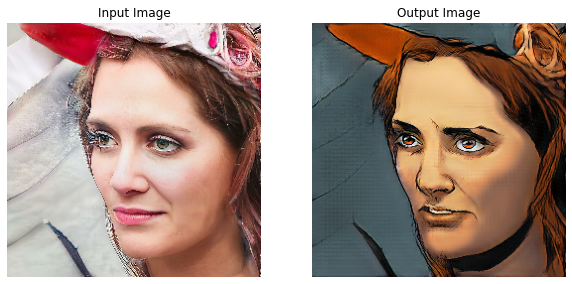

2022-12-04 00:18:27.430415: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 195649, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670113107.430214687","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 195649, Output num: 0","grpc_status":3}


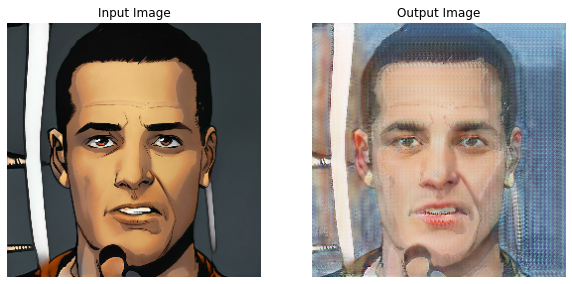

Epoch 32/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7278 - face_gen_loss: 2.3981 - comic_disc_loss: 0.5613 - face_disc_loss: 0.6434
Epoch 33/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8617 - face_gen_loss: 2.4819 - comic_disc_loss: 0.5112 - face_disc_loss: 0.6322
Epoch 34/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.4088 - face_gen_loss: 2.3368 - comic_disc_loss: 0.6489 - face_disc_loss: 0.6328
Epoch 35/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.5705 - face_gen_loss: 2.3299 - comic_disc_loss: 0.5688 - face_disc_loss: 0.6420
Epoch 36/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7771 - face_gen_loss: 2.3701 - comic_disc_loss: 0.5214 - face_disc_loss: 0.6414


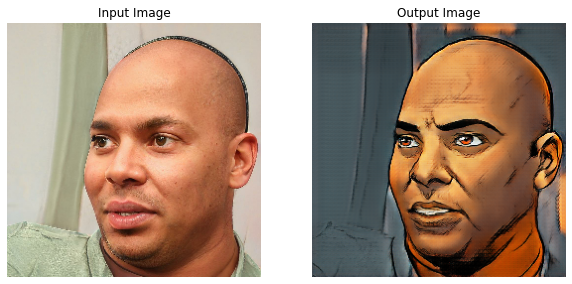

2022-12-04 00:36:49.307041: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 220391, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670114209.306953743","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 220391, Output num: 1","grpc_status":3}


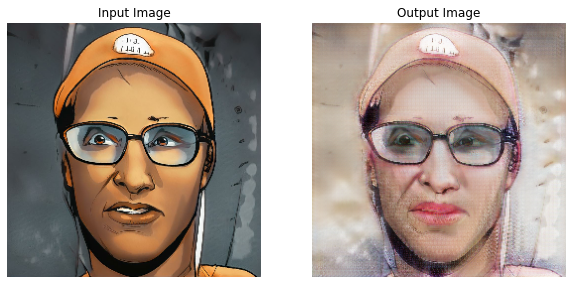

Epoch 37/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 3.0584 - face_gen_loss: 2.7384 - comic_disc_loss: 0.5005 - face_disc_loss: 0.6039
Epoch 38/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7303 - face_gen_loss: 2.3856 - comic_disc_loss: 0.5544 - face_disc_loss: 0.6454
Epoch 39/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8558 - face_gen_loss: 2.4181 - comic_disc_loss: 0.5034 - face_disc_loss: 0.6432
Epoch 40/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7782 - face_gen_loss: 2.3909 - comic_disc_loss: 0.5397 - face_disc_loss: 0.6457
Epoch 41/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7044 - face_gen_loss: 2.3588 - comic_disc_loss: 0.5602 - face_disc_loss: 0.6387


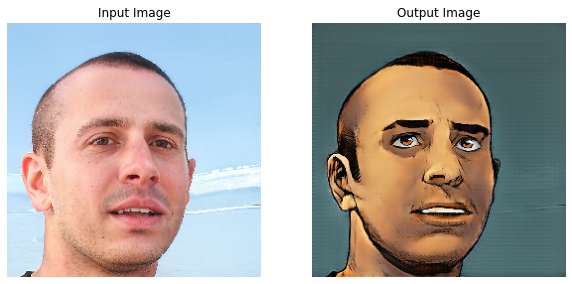

2022-12-04 00:55:10.721431: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 244925, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670115310.721335079","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 244925, Output num: 1","grpc_status":3}


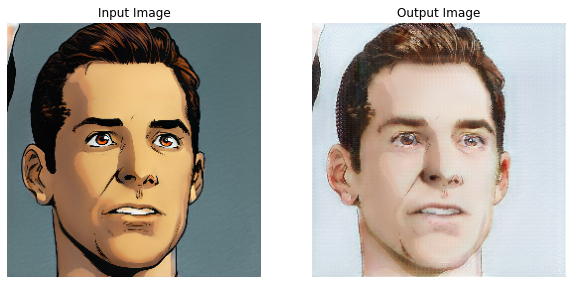

Epoch 42/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7164 - face_gen_loss: 2.3616 - comic_disc_loss: 0.5690 - face_disc_loss: 0.6403
Epoch 43/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.6096 - face_gen_loss: 2.3098 - comic_disc_loss: 0.5411 - face_disc_loss: 0.6398
Epoch 44/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8448 - face_gen_loss: 2.3761 - comic_disc_loss: 0.5102 - face_disc_loss: 0.6407
Epoch 45/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8104 - face_gen_loss: 2.3375 - comic_disc_loss: 0.5185 - face_disc_loss: 0.6459
Epoch 46/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.5743 - face_gen_loss: 2.2929 - comic_disc_loss: 0.5918 - face_disc_loss: 0.6437


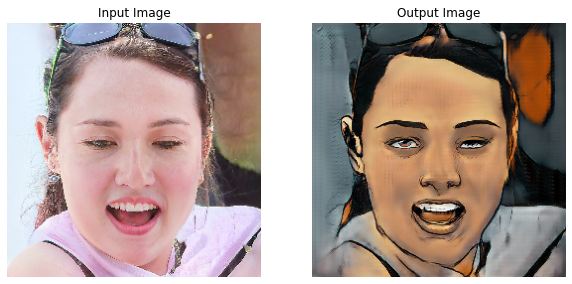

2022-12-04 01:13:32.239894: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 269667, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670116412.239727316","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 269667, Output num: 0","grpc_status":3}


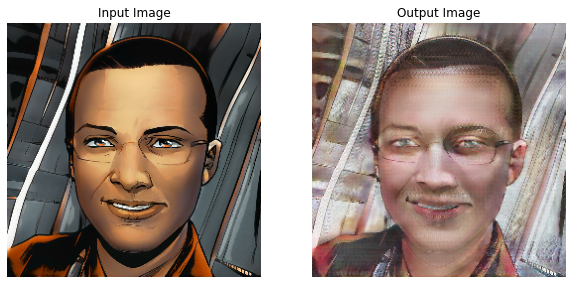

Epoch 47/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 3.3575 - face_gen_loss: 3.2943 - comic_disc_loss: 0.4770 - face_disc_loss: 0.5377
Epoch 48/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.7994 - face_gen_loss: 2.4035 - comic_disc_loss: 0.5454 - face_disc_loss: 0.6470
Epoch 49/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.8789 - face_gen_loss: 2.3649 - comic_disc_loss: 0.4883 - face_disc_loss: 0.6420
Epoch 50/50
532/532 [==============================] - 217s 408ms/step - comic_gen_loss: 2.3112 - face_gen_loss: 2.2340 - comic_disc_loss: 0.6683 - face_disc_loss: 0.6403


In [36]:
# shuffle 시간이 걸림. 10번마다 진행보여주고 저장 
history = cyclegan_model.fit(train_ds, epochs=50,verbose=True,callbacks=[ganmonitor(save_epoch=10,watch_epoch=5)],steps_per_epoch=STEP,initial_epoch=0, validation_data=test_ds)

In [98]:
# comic_gen_loss = np.asarray(history.history['comic_gen_loss'])
# face_gen_loss = np.asarray(history.history['face_gen_loss'])
# comic_disc_loss = np.asarray(history.history['comic_disc_loss'])
# face_disc_loss = np.asarray(history.history['face_disc_loss'])
# n = 0
# comic_gen_loss = comic_gen_loss[:, n, n,n]
# face_gen_loss = face_gen_loss[:, n, n,n]
# comic_disc_loss = comic_disc_loss[:, n, n,n]
# face_disc_loss = face_disc_loss[:, n, n,n]

In [117]:
# comic_gen_loss = np.asarray(history.history['comic_gen_loss']).mean(axis=1)
# comic_gen_loss = comic_gen_loss[:, n, n]